In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
matplotlib 3.8.4
numpy 1.26.4
pandas 2.2.2
sklearn 1.4.2
torch 2.2.2+cpu
cpu


## 数据准备

In [2]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

--2024-05-02 11:33:52--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.42.251, 172.217.163.59, 142.251.43.27
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.42.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'shakespeare.txt.1'

     0K .......... .......... .......... .......... ..........  4% 1.11M 1s
    50K .......... .......... .......... .......... ..........  9% 2.06M 1s
   100K .......... .......... .......... .......... .......... 13% 3.26M 1s
   150K .......... .......... .......... .......... .......... 18% 5.05M 0s
   200K .......... .......... .......... .......... .......... 22% 5.38M 0s
   250K .......... .......... .......... .......... .......... 27% 7.16M 0s
   300K .......... .......... .......... .......... .......... 32% 8.86M 0s
   350K .......... .......... .......... ........

In [3]:
# https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
#文件已经下载好了
with open("./shakespeare.txt", "r", encoding="utf8") as file:
    text = file.read()

print("length", len(text))
print(text[0:100])

length 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### 构造字典

In [4]:
# 1. generate vocab
# 2. build mapping char->id
# 3. data -> id_data  把数据都转为id
# 4. a b c d [EOS] -> [BOS] b c d  预测下一个字符生成的模型，也就是输入是a，输出就是b

#去重，留下独立字符，并排序
vocab = sorted(set(text))
print(len(vocab))
print(vocab)

65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
for idx,char in enumerate(['how','are','you']):
    print(idx,char)

0 how
1 are
2 you


In [6]:
#每个字符都编好号，enumerate对每一个位置编号，生成的是列表中是元组，下面字典生成式
char2idx = {char:idx for idx, char in enumerate(vocab)}
print(char2idx)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [7]:
# 把vocab从列表变为ndarray
idx2char = np.array(vocab)
print(idx2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [9]:
#把字符都转换为id
text_as_int = np.array([char2idx[c] for c in text])
print(text_as_int.shape)
print(len(text_as_int))
print(text_as_int[0:10])
print(text[0:10])

(1115394,)
1115394
[18 47 56 57 58  1 15 47 58 47]
First Citi


### 把莎士比亚文集分成一个一个的样本

In [10]:
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    #text_as_int是字符的id列表，seq_length是每个样本的长度
    def __init__(self, text_as_int, seq_length):
        self.sub_len = seq_length + 1 #一个样本的长度
        self.text_as_int = text_as_int
        self.num_seq = len(text_as_int) // self.sub_len #样本的个数
        
    def __getitem__(self, index):#index是样本的索引，返回的是一个样本，比如第一个，就是0-100的字符
        return self.text_as_int[index * self.sub_len: (index + 1) * self.sub_len]
    
    def __len__(self): #返回样本的个数
        return self.num_seq

#batch是一个列表，列表中的每一个元素是一个样本，有101个字符，前100个是输入，后100个是输出
def collat_fct(batch):
    src_list = []
    trg_list = []
    for part in batch:
        src_list.append(part[:-1]) #输入
        trg_list.append(part[1:]) #输出
        
    src_list = np.array(src_list) #把列表转换为ndarray
    trg_list = np.array(trg_list) #把列表转换为ndarray
    return torch.Tensor(src_list).to(dtype=torch.int64), torch.Tensor(trg_list).to(dtype=torch.int64) #返回的是一个元组，元组中的每一个元素是一个torch.Tensor
        

train_ds = CharDataset(text_as_int, 100)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collat_fct)

## 定义模型

In [15]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=1024):
        super(CharRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #batch_first=True,输入的数据格式是(batch_size, seq_len, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.rnn(x, hidden) #这里和02的差异是没有只拿最后一个输出，而是把所有的输出都拿出来了
        x = self.fc(output) #[bs, seq_len, hidden_dim]
        return x, hidden #x的shape是(batch_size, seq_len, vocab_size)
    
    
vocab_size = len(vocab)
sample_inputs = torch.randint(0, vocab_size, (1, 100))
print(sample_inputs)
print("{:=^80}".format(" 一层单向 RNN "))       
for key, value in CharRNN(vocab_size).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")
print("{:=^80}".format(""))
CharRNN(vocab_size)(sample_inputs)[0].shape

tensor([[41, 13, 56, 55,  0, 45, 64, 48, 11, 48, 57, 31, 57, 16, 10,  7,  1,  0,
         45, 34, 13, 20, 36, 23, 56, 11, 10, 58, 52, 40, 45,  7, 22, 11, 47, 22,
          8, 22, 20, 30, 47, 14,  8, 22, 52, 17, 40, 55, 53, 16, 30, 22, 20, 22,
         51, 55, 50, 35, 30,  6, 38, 21, 17,  8, 23,  0,  7,  3,  8, 49, 28,  1,
         33, 24, 26, 48, 61, 41, 20, 53, 38, 30, 58, 29, 38, 24, 48, 37, 15, 13,
         53, 55, 35, 12, 25, 17, 35, 17, 62, 56]])
=================================== 一层单向 RNN ===================================
            embedding.weight            paramerters num: 16640
            rnn.weight_ih_l0            paramerters num: 262144
            rnn.weight_hh_l0            paramerters num: 1048576
             rnn.bias_ih_l0             paramerters num: 1024
             rnn.bias_hh_l0             paramerters num: 1024
               fc.weight                paramerters num: 66560
                fc.bias                 paramerters num: 65


torch.Size([1, 100, 65])

In [18]:
256*1024
1024*1024
1024*65

66560

In [19]:
my_tensor = torch.randint(0, vocab_size, (64, 100))

In [21]:
my_tensor.reshape(-1).shape

torch.Size([6400])

## 训练

In [11]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [12]:
# 训练
def training(
    model, 
    train_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    save_ckpt_callback=None,
    stateful=False      # 想用stateful，batch里的数据就必须连续，不能打乱
    ):
    record_dict = {
        "train": [],
    }
    
    global_step = 0
    model.train()
    hidden = None
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits, hidden = model(datas, hidden=hidden if stateful else None)
                # 计算损失
                loss = loss_fct(logits.reshape(-1, vocab_size), labels.reshape(-1))
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
 
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
   
                # 保存模型权重 save model checkpoint
                if save_ckpt_callback is not None:
                    save_ckpt_callback(global_step, model.state_dict(), metric=-loss)
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 100

model = CharRNN(vocab_size=vocab_size)

# 1. 定义损失函数 采用交叉熵损失 
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/text_generation", save_step=1000, save_best_only=True)


model = model.to(device)
record = training(
    model, 
    train_dl, 
    epoch, 
    loss_fct, 
    optimizer, 
    save_ckpt_callback=save_ckpt_callback,
    )

  0%|          | 0/17300 [00:00<?, ?it/s]

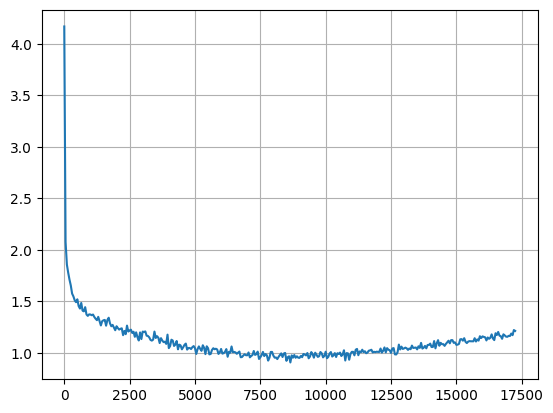

In [13]:
plt.plot([i["step"] for i in record["train"][::50]], [i["loss"] for i in record["train"][::50]], label="train")
plt.grid()
plt.show()

## 推理

In [23]:
#
my_tensor = torch.tensor([0.2,0.3])

probs1 = F.softmax(my_tensor, dim=-1)
print(probs1)

tensor([0.4750, 0.5250])


In [31]:
import torch

# 创建一个概率分布，表示每个类别被选中的概率
# 这里我们有一个简单的四个类别的概率分布
prob_dist = torch.tensor([0.1, 0.45, 0.35, 0.1])

# 使用 multinomial 进行抽样
# num_samples 表示要抽取的样本数量
num_samples = 5

# 抽取样本
samples = torch.multinomial(prob_dist, 1, replacement=True)

print("概率分布:", prob_dist)
print("抽取的样本索引:", samples)

# 显示每个样本对应的概率
print("每个样本对应的概率:", prob_dist[samples])

概率分布: tensor([0.1000, 0.4500, 0.3500, 0.1000])
抽取的样本索引: tensor([1])
每个样本对应的概率: tensor([0.4500])


In [25]:
def generate_text(model, start_string, max_len=1000, temperature=1.0, stream=True):
    input_eval = torch.Tensor([char2idx[char] for char in start_string]).to(dtype=torch.int64, device=device).reshape(1, -1) #bacth_size=1, seq_len长度是多少都可以
    hidden = None
    text_generated = [] #用来保存生成的文本
    model.eval()
    pbar = tqdm(range(max_len)) # 进度条
    print(start_string, end="")
    # no_grad是一个上下文管理器，用于指定在其中的代码块中不需要计算梯度。在这个区域内，不会记录梯度信息，用于在生成文本时不影响模型权重。
    with torch.no_grad():
        for i in pbar:
            logits, hidden = model(input_eval, hidden=hidden)
            # 温度采样，较高的温度会增加预测结果的多样性，较低的温度则更加保守。
            logits = logits[0, -1, :] / temperature
            # using multinomial to sampling
            probs = F.softmax(logits, dim=-1) #算为概率分布
            idx = torch.multinomial(probs, 1).item() #从概率分布中抽取一个样本,取概率较大的那些
            input_eval = torch.Tensor([idx]).to(dtype=torch.int64, device=device).reshape(1, -1) #把idx转为tensor
            text_generated.append(idx)
            #流式输出，程序会在生成每个字符时立即打印出来，这样能看到实时更新
            if stream:
                print(idx2char[idx], end="", flush=True)
    return "".join([idx2char[i] for i in text_generated])


# load checkpoints
model.load_state_dict(torch.load("checkpoints/text_generation/best.ckpt", map_location="cpu"))
start_string = "All: "
res = generate_text(model, start_string, max_len=1000, temperature=0.5, stream=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

All: I must conference were early is full of soldiers:
Therefore this be courtedy state,
When he would have spoke, that follows that you make me burning welcome.

PETRUCHIO:
The fouler face. But then for his majesty
To revel it is become and stocan, and that he will be therefore can bear your patience.

CAMILLO:
Sir, the great Bolingbroke, dispersed again, being the first punishment,
Or breathes of that contented that hath not safegualing whiterately heart
May do me swear and me.

QUEEN ELIZABETH:
But I pray you, let me have
A drops of such a passing sounds,
But that the rage, my lord,
Go their wives,
and that thou wert death:
And streal occasion to his children from the world,
Than the desperate greater than a soldiers to his place.

CAMILLO:
Sir, so in this crown,
And so he do not slaughter of the twofold chamber; but the king
Shall give me see
these free deposed?

Gardener:
Doth the devil that fills her on the sun.

DUCHESS OF YORK:
Why, therefore take my leave.

QUEEN MARGARET:
Wha